In [1]:
import matplotlib.pyplot as plt
import os, sys
from ase.io import read
from ase.units import Hartree

import time
import rascal
import json

from ase.io import read, write
from ase.visualize import view
import numpy as np
import sys


In [2]:
from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                          lm_slice, real2complex_matrix, xyz_to_spherical, spherical_to_xyz)
from rascal.utils.cg_utils import _rotation as rotation

In [3]:
from tqdm.notebook import tqdm
class tqdm_reusable:
    def __init__(self, *args, **kwargs):
        self._args = args
        self._kwargs = kwargs

    def __iter__(self):
        return tqdm(*self._args, **self._kwargs).__iter__()

In general, an atomistic property of interest may be indexed by N atomic indices $y_{i i_2 \ldots i_N}$ instead of just one. This calls for features that also have a similar behavior. Let's restrict to the case of two centers. An example of such a property is the Hamiltonian in the AO basis 
#### tilde indices for orbitals (don't confuse with nlm used for projection basis of features)
$\newcommand{\Hhat}{\hat{H}}$
$\newcommand{\te}{\tilde{a}}$
$\newcommand{\tn}{\tilde{n}}$
$\newcommand{\tl}{\tilde{l}}$
$\newcommand{\tm}{\tilde{m}}$
$\newcommand{\tlm}{\tl\tm}$
$\newcommand{\tnlm}{\tnl\tm}$
$\newcommand{\tnl}{\tn\tl}$
$\newcommand{\tnnlammu}{\tnl_1;\tnl_2;\lambda\mu}$


$$
\langle \te_1 \tnlm_1; \te_2 \tnlm_2 | \Hhat | A_{ii_2} \rangle
$$
represents the element the matrix correspoding to orbital $|\tnlm_1 \rangle$ centered on atom $i$ with species $|\te_1\rangle$ and the orbital $|\tnlm_2 \rangle$ centered on atom $i_2$ with species $|\te_2\rangle$. 

Following the CG iteration, we can transform to the coupled basis as 
$$
\langle \te_1 \tnl_1; \te_2 \tnl_2 | \Hhat | A_{ii_2}; \lambda \mu \rangle
$$

In line with the SA-GPR framework in atomistic ML, we learn the corresponding rotationally equivariant elements with features obeying the same symmetry
$$
\langle a_1 n_1 l_1; a_2 n_2; l_2 | \overline{\rho_{i i_2}^{\otimes 1}; \lambda\mu} \rangle = 
\sum_{m_1 m_2} 
\langle a_1 n_1 l_1 m_1 | g; \mathbf{r}_{i i_2} \rangle  \langle a_2 n_2 l_2 m_2 | \rho_i \rangle
\langle l_1m_1; l_2 m_2 | \lambda\mu \rangle
$$

This resembles closely the the NICE iteration, therefore we can easily increase the number of centers / correlation order.  [Nigam et al., 2021](http://arxiv.org/abs/2109.12083)]

Let's try to learn the hamiltonian of water molecules using an effective core potential (ECP) for oxygen and a basis which corresponds to 1s, 2s orbitals on Hydrogen and 1s, 2s, 2p$_x$, 2p$_y$,2p$_z$ + three 3p orbitals on Oxygen  that are then Loewdin orthogonalized

In [4]:
import sys
sys.path.insert(0,'/Users/jigyasa/scratch/ncenter-reps/')
# sys.path.insert(0,'/home/nigam/git/ncenter-reps/')

In [5]:
from ncnice import * 

In [6]:
spherical_expansion_hypers = {
    "interaction_cutoff": 4,
    "max_radial": 8,
    "max_angular": 6,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
}
CG = ClebschGordanReal(spherical_expansion_hypers["max_angular"])
abc = np.random.uniform(size=(3))*np.pi
WD = WignerDReal(spherical_expansion_hypers["max_angular"], *abc)

### Load frames, orbitals, orthogonal fock matrices 

In [7]:
N=50
frames = read('../data/water-example/water_coords_1000.xyz', ':'+str(N))
for i in range(len(frames)):
    frames[i].cell= [40,40,40]
    frames[i].positions+=20
    frames[i].pbc=False
    
orbs = json.loads(json.load(open('../data/water-example/water_orbs.json', "r")))
orbs_def2 = json.loads(json.load(open('../data/water-example/orbs_def2_water.json', "r")))
fock_def2 = np.load('../data/water-example/water_fock.npy', allow_pickle=True)
overlap_def2 =  np.load('../data/water-example/water_overlap.npy', allow_pickle=True)

The matrices calculated by PySCF, for l=1 orbitals, are ordered in a way that m=1, -1, 0. These need to be reordered so they are organized like the rest of the orbitals with m= -l, -l+1, ..., l-1, l

In [8]:
for i in range(len(frames)):
    fock_def2[i] = fix_pyscf_l1(fock_def2[i], frames[i], orbs_def2)
    overlap_def2[i] = fix_pyscf_l1(overlap_def2[i], frames[i], orbs_def2)

The fock matrices can be projected from the AO basis to the Loewdin orthogonalized basis 

In [9]:
ortho_fock_def2 =[]
for i in range(len(frames)):
    ortho_fock_def2.append(lowdin_orthogonalize(fock_def2[i], overlap_def2[i]))
ortho_fock_def2 = np.asarray(ortho_fock_def2)

In [10]:
ortho_fock_saph =  np.load('../data/water-example/water_saph_orthogonal.npy', allow_pickle=True)

From hereon, we work explicitly with the orthogonalized **SAPH**. You can experiment with the matrices in the def2-SVP basis by working with corresponding orbitals (orbs_def2). Remember to set lmax=4 for this case when computing the feature

### Decomposition of hamiltonian into different blocks

In [11]:
uncoupled_ortho_blocks = matrix_to_blocks(ortho_fock_saph[21], frames[21], orbs)
coupled_ortho_blocks = couple_blocks(uncoupled_ortho_blocks, CG)

There are some additional symmetries when working with multiple centers, relating to permutation of labels which correlates to the symmetry of hamiltonians under exchange of identical atoms. See slides

### Verify the rotational behavior of predicted hamiltonian blocks

Invariance of $\lambda=0$ blocks

In [12]:
WD.rotate(coupled_ortho_blocks['diag'][(2,0,2,0)][0]) - coupled_ortho_blocks['diag'][(2,0,2,0)][0]

array([[0.]])

In [13]:
frame = frames[21]

feats = compute_hamiltonian_representations([frame], orbs, spherical_expansion_hypers, lmax=2, nu=1, cg=CG, scale=1e3)

### Fitting and predicting 

In [14]:
print("Fitting model")
FR = FockRegression(orbs, alpha=1e-8, fit_intercept="auto")
FR.fit(feats, coupled_ortho_blocks)

print("Predicting model")
pred_coupled = FR.predict(feats)
pred = blocks_to_matrix(decouple_blocks(pred_coupled, CG), frame, orbs)

print("RMSE Hamiltonian", np.linalg.norm(ortho_fock_saph[23]-pred)/np.sqrt(len(ortho_fock_saph[21])))
print("MAE Eigenvalues", np.mean(np.abs(np.linalg.eigvalsh(ortho_fock_saph[21])-np.linalg.eigvalsh(pred))))

Fitting model
Fitting  diag:         (2, 0, 2, 0)
diag (2, 0, 2, 0) ('O', 0, 1) 0 0.8074352492243758
Fitting  diag:         (2, 0, 2, 1)
diag (2, 0, 2, 1) ('O', 1, 1) 1 0.1539678132921088
Fitting  diag:         (2, 1, 2, 1)
diag (2, 1, 2, 1) ('O', 0, 1) 0 0.64641251695997
diag (2, 1, 2, 1) ('O', 2, 1) 2 0.2115781353666423
Fitting  diag:         (3, 0, 3, 0)
diag (3, 0, 3, 0) ('H', 0, 1) 0 0.5777557839931945
Fitting offd_p:         (3, 0, 3, 0)
offd_p (3, 0, 3, 0) ('H', 0, 1) 0 0.22946907720017526
Fitting offd_m:         (3, 0, 3, 0)
Fitting  hete:         (2, 0, 3, 0)
hete (2, 0, 3, 0) ('O', 'H', 0, 1) 0 0.6567904056965445
Fitting  hete:         (2, 1, 3, 0)
hete (2, 1, 3, 0) ('O', 'H', 1, 1) 1 0.5890536654609094
Predicting model
RMSE Hamiltonian 0.13393825710636556
MAE Eigenvalues 0.02554303901101532


### Predict a structure that is rotated and atoms permuted 

In [15]:
frame_rotperm = frame.copy()
iperm = np.arange(len(frame.numbers), dtype=int)
np.random.shuffle(iperm)
frame_rotperm.numbers = frame_rotperm.numbers[iperm]
frame_rotperm.positions = frame_rotperm.positions[iperm]
print(frame_rotperm.symbols)

abc = np.random.uniform(size=(3))*np.pi
WD = WignerDReal(spherical_expansion_hypers["max_angular"], *abc)
WD.rotate_frame(frame_rotperm)

H2O


Atoms(symbols='H2O', pbc=False, cell=[[-6.735174437201676, 31.632474526770757, -23.537714005690194], [-39.24745437227104, -7.666663118130481, 0.9271471995321323], [-3.778194092019028, 23.250996364592574, 32.328260353083266]])

In [16]:
frame_list = [frame, frame_rotperm ]
# view(frame_list) #visualize actual and rotated-permuted structure

In [17]:
feats_rotperm = compute_hamiltonian_representations([frame_rotperm], orbs, spherical_expansion_hypers, lmax=2, nu=1, cg=CG, scale=1e3)
pred_rotperm = blocks_to_matrix(decouple_blocks(FR.predict(feats_rotperm), CG), frame, orbs)

print("RMSE Hamiltonian (pred)", np.linalg.norm(pred_rotperm-pred)/np.sqrt(len(ortho_fock_saph[213])))
print("MAE Eigenvalues (pred)", np.mean(np.abs(np.linalg.eigvalsh(pred_rotperm)-np.linalg.eigvalsh(pred))))


RMSE Hamiltonian (pred) 0.5141336109420714
MAE Eigenvalues (pred) 3.469446951953614e-16


Text(0.5, 0, 'k')

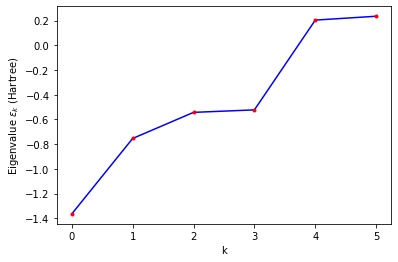

In [18]:
plt.plot(np.linalg.eigvalsh(pred), 'b')
plt.plot(np.linalg.eigvalsh(pred_rotperm), 'r.')
plt.ylabel(r'Eigenvalue $\epsilon_k$ (Hartree)')
plt.xlabel('k')

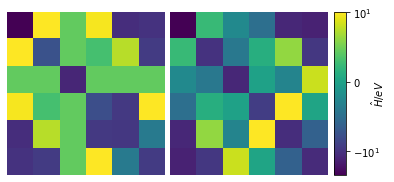

In [19]:
mats = [pred*Hartree, pred_rotperm*Hartree]
import matplotlib.gridspec as gridspec
import matplotlib
fig= plt.figure(figsize=(9,3))
gs = gridspec.GridSpec(1, 4, width_ratios=(1,1,0.08, 1))
gs.update(wspace=0.05)
gs.update(hspace=0.01)
# gs.update(width_ratios='1:1')
ax1 = plt.subplot(gs[0, 0], )
ax2 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[0, 2])

for i,ax in enumerate([ax1,ax2]):
    im = ax.matshow(mats[i], norm=matplotlib.colors.SymLogNorm(linthresh=5, linscale=1), aspect="auto")
    ax.axis('off')

c = fig.colorbar(im,fraction=0.026, pad=0.046,cax=ax4,orientation="vertical")
c.set_label(r'$\hat{H}/ eV$', rotation=90, labelpad=-10, y=0.5)
ax= c.ax
# ax.xaxis.set_ticks_position('right')
# ax.xaxis.set_label_position('right')
# ax.text(1.2,2,r'$\hat{H}(eV)$', fontsize=13, rotation=90)
# c.ax.xaxis.set_ticks(minor_ticks, minor=True) 
c.set_ticks([[-100., -500., -10.,   0.,   10.,  100., 500.]])
ax.xaxis.set_tick_params(pad=-2)

### Let's do this for a larger dataset 

In [20]:
#function to define the training blocks
def slice_fraction(blocks, tf = 0.5):
    train_slices = {}
    for k in blocks.keys():
        train_slices[k] = {}
        for orb in blocks[k]:
            if list(blocks[k][orb].keys()):
#                 print(k, orb, list(blocks[k][orb].keys()))
                L0 = list(blocks[k][orb].keys())[0]
                train_slices[k][orb] = slice(0,int(len(blocks[k][orb][L0])*tf))
            else: 
                train_slices[k][orb] = None
                
    return train_slices

In [21]:
coupled_ortho_blocks, slices = matrix_list_to_blocks(ortho_fock_saph[:50], frames[:50], orbs, CG)

In [22]:
train_slices = slice_fraction(coupled_ortho_blocks, tf=0.8)

In [23]:
feats = compute_hamiltonian_representations(frames[:50], orbs, spherical_expansion_hypers, lmax=2, nu=1, cg=CG, scale=1e3)

In [24]:
# substitute nu=2 features for the "diagonal" block
blocks = uncoupled_ortho_blocks
blocks_c = coupled_ortho_blocks 
tblock = 'diag'
sel_type  = list(blocks[tblock].keys())
fblock=[]
for i in range(len(sel_type)):
    kblock = sel_type[i]
    lblock = list(blocks_c['diag'][sel_type[i]].keys())
    for l in lblock:
        fblock.append(block_to_feat_index(tblock, kblock, l, orbs))

fblock = list(set(fblock))
for j in fblock:
    print(j)
    feats['diag'][j] = compute_hamiltonian_representations(tqdm_reusable(frames, desc="features"), orbs = orbs, hypers = spherical_expansion_hypers,lmax=2, nu=2, cg=CG, scale=1e3, select_feats=dict(block=j, type=tblock))[tblock][j]

('H', 0, 1)


features:   0%|          | 0/50 [00:00<?, ?it/s]

features:   0%|          | 0/50 [00:00<?, ?it/s]

('O', 0, 1)


features:   0%|          | 0/50 [00:00<?, ?it/s]

features:   0%|          | 0/50 [00:00<?, ?it/s]

('O', 2, 1)


features:   0%|          | 0/50 [00:00<?, ?it/s]

features:   0%|          | 0/50 [00:00<?, ?it/s]

('O', 1, 1)


features:   0%|          | 0/50 [00:00<?, ?it/s]

features:   0%|          | 0/50 [00:00<?, ?it/s]

### Run regression

In [25]:
FR = FockRegression(orbs, alphas = np.geomspace(1e-8,1e8, 12))

In [26]:
FR.fit(feats, coupled_ortho_blocks, train_slices, progress=tqdm)

  0%|          | 0/4 [00:00<?, ?it/s]

diag (2, 0, 2, 0) ('O', 0, 1) 0 5.417893290031105
diag (2, 0, 2, 1) ('O', 1, 1) 1 0.9201424305378398
diag (2, 1, 2, 1) ('O', 0, 1) 0 3.852430966839688
diag (2, 1, 2, 1) ('O', 2, 1) 2 1.40818336048713
diag (3, 0, 3, 0) ('H', 0, 1) 0 3.3084881777001813


  0%|          | 0/1 [00:00<?, ?it/s]

offd_p (3, 0, 3, 0) ('H', 0, 1) 0 1.0836512991983627


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

hete (2, 0, 3, 0) ('O', 'H', 0, 1) 0 3.8553466514604695
hete (2, 1, 3, 0) ('O', 'H', 1, 1) 1 3.5096580046045047


In [27]:
pred_blocks = FR.predict(feats, progress=tqdm)
pred_matrix = blocks_to_matrix_list(pred_blocks, frames, slices, orbs, CG)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

##### pred_matrix is a list of all predictions. Remember we trained on the first 40 structures! 

### Post diagnostics 

#### Utilities to run post diagnostics

In [28]:
def get_homo_lumo(frames, eva, peva, noffset=0, eV=False):
    leva = []
    npairs = []
    homo = []
    lumo = []
    phomo = []
    plumo = []
    nat = []
    phomo_gen = []
    plumo_gen = []
    for i,f in enumerate(frames[:]):
        ev = eva[i]
        pev = peva[i]
#         print(pev.shape)
#         leva.append(eva)
        nel = 0
        for z in f.numbers:
            nel += z
        nel = nel-noffset
        #print(nel, noffset)
        if (nel%2 !=0):
            print ("Radical alert!")
        nat.append(len(f.numbers))
        npairs.append(nel//2)
        homo.append(ev[nel//2-1])
        lumo.append(ev[nel//2])
        phomo.append(pev[nel//2-1])
        plumo.append(pev[nel//2])
    npairs = np.asarray(npairs, dtype=int)
    homo = np.asarray(homo)
    lumo = np.asarray(lumo)
    phomo = np.asarray(phomo)
    plumo = np.asarray(plumo)
    pgap = plumo-phomo
    gap = lumo-homo
    if(eV==False):
        return homo, lumo,gap, phomo, plumo, pgap
    else:
        return homo*Hartree, lumo*Hartree,gap*Hartree, phomo*Hartree, plumo*Hartree, pgap*Hartree


def get_mae (x, y):
#     return np.sum(np.abs(x-y))/len(x)
    return np.mean(np.abs(x-y))

def get_rmse(x, y):
    return np.sqrt(np.mean((x-y)**2, axis = 1))

def block_err(pred, frames, orbs, mycg, fock, itest):
    lcstats = {}
    blocks, slices = matrix_list_to_blocks(fock, frames, orbs, mycg)
    lcstats['block_lc_mse'] ={k:[] for k in ["diag", "hete", "offd_m", "offd_p"]}
    block_rmse_test_tf=[]
    full_mse_test_tf=[]
    lcstats['full_mse_test_tf'] = full_mse_test_tf
 #   for itf, tf in enumerate(trainfrac):
    lcblocks, slices = matrix_list_to_blocks(pred, frames, orbs, mycg)

    test_slices = get_block_idx(itest, slices)
    print("Computing errors")
    block_mse_test = {}
    block_rmse_test = {}
    block_rmse_test_list = {}
    for k in blocks.keys():
        for b in blocks[k]:
            for l in blocks[k][b]:
                block_mse_test[(k,b,l)] = 0
                block_rmse_test_list[(k,b,l)] = []
                #  weighting factors to get the same sum as for the full Hamiltonian
                na, la, nb, lb = b
                if (nb==na and lb==la):
                    fac = 1
                else:
                    fac = 2
                if k in ["offd_m", "offd_p"]:
                    fac*=1#0.5

                for t in itest:
                    if not b in slices[t][k]:
                        block_rmse_test_list[(k,b,l)].append(0)
                        continue
                    block_rmse_test_list[(k,b,l)].append(np.sqrt(((blocks[k][b][l][slices[t][k][b]] - lcblocks[k][b][l][slices[t][k][b]]).flatten()**2).sum()))
                    block_mse_test[(k,b,l)] += ((blocks[k][b][l][slices[t][k][b]] - lcblocks[k][b][l][slices[t][k][b]]).flatten()**2).sum()  / len(fock[t]) *fac
                block_rmse_test[(k,b,l)] = np.sqrt(block_mse_test[(k,b,l)]/len(itest))
    full_mse_test = 0
    for t in itest:
        full_mse_test += np.sum((fock[t] - pred[t])**2)/len(fock[t])
    full_mse_test /= len(itest)
    print("Full MSE test", full_mse_test)
    full_mse_test_tf.append(full_mse_test)
    block_rmse_test_tf.append(block_rmse_test)
    tot = { k:0 for k in ["diag", "hete", "offd_m", "offd_p"] }
    for bb in block_rmse_test.keys():
        tot[bb[0]] += block_rmse_test[bb]**2
    print("Sum of block errors", tot['diag']+tot['hete']+(tot['offd_p']+tot['offd_m']))
    for k in ["diag", "hete", "offd_m", "offd_p"] :
        lcstats['block_lc_mse'][k].append(tot[k])
#         print(tot[k])
    lcstats['full_mse_test_tf'] = full_mse_test_tf


    return full_mse_test_tf, block_rmse_test_tf, lcstats

def full_error(trainfrac, pred_list, fock, itest):
    full_rmse_test_tf=[]
    for itf, tf in enumerate(trainfrac):
        pred = pred_list[itf]
        full_mse_test = 0
        for t in itest:
            full_mse_test += np.sum((fock[t] - pred[t])**2)/len(fock[t])
        full_mse_test /= len(itest)
        print(tf, full_mse_test)
        full_rmse_test_tf.append(np.sqrt(full_mse_test))
    return np.asarray(full_rmse_test_tf)


#### How does the eigenvalue spectum compare? What's the error on the HOMO-LUMO gaps, which blocks do better than others? 

In [29]:
test_matrix = ortho_fock_saph[40:50]
train_matrix = ortho_fock_saph[:40]
eigenval_norm = np.asarray([ np.sqrt(np.mean((np.linalg.eigvalsh(pred_matrix[len(train_matrix)+j])-np.linalg.eigvalsh(ortho_fock_saph[len(train_matrix)+j].astype(float)))**2
                                          )) for j in range(len(test_matrix))  ])
eigenval_rmse = np.sqrt(np.sum(eigenval_norm**2)/len(test_matrix))

print("error on the Eigenvalue spectrum/eV", eigenval_rmse*Hartree)

error on the Eigenvalue spectrum/eV 0.0019606271459226697


#### HOMO-LUMO gaps

In [30]:
import matplotlib as mpl

In [31]:
ref_eig = np.linalg.eigvalsh(ortho_fock_saph[40:50])
pred_eig =  np.linalg.eigvalsh(pred_matrix[40:50])

homo, lumo,gap, phomo, plumo, pgap  = get_homo_lumo(frames[40:50], ref_eig, pred_eig,noffset=2, eV=True)

Text(0, 0.5, '$\\delta$(HF)/eV')

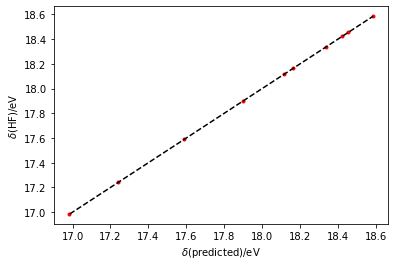

In [32]:
fig, ax = plt.subplots(1,1)
ax.plot(pgap,  gap,'r.')
ax.plot([min(gap),max(gap)],[min(gap),max(gap)],'k--')
fmt = mpl.ticker.ScalarFormatter(); fmt.set_scientific(False)
# ax.xaxis.set_major_formatter(fmt)
# ax.xaxis.set_minor_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_minor_formatter(fmt)
ax.ticklabel_format(useOffset=False)
ax.set_xlabel("$\delta$(predicted)/eV")
ax.set_ylabel("$\delta$(HF)/eV")

Block wise errors in Ha

In [33]:
full_mse, block_rmse, lcstats  = block_err(pred_matrix, frames[:50], orbs, CG, ortho_fock_saph[:50], list(range(40,50)) )

Computing errors
Full MSE test 1.0765344578954867e-08
Sum of block errors 1.076534457895489e-08


In [34]:
lcstats

{'block_lc_mse': {'diag': [7.654803388829133e-09],
  'hete': [2.609683903428468e-09],
  'offd_m': [0],
  'offd_p': [5.008572866972897e-10]},
 'full_mse_test_tf': [1.0765344578954867e-08]}